2025-01-11 07:58:12.782480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-11 07:58:12.897450: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 07:58:12.932157: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 07:58:13.512820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Epoch 1/100


2025-01-11 07:58:23.868999: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


33/33 [==============================] - 10s 111ms/step - loss: 1.6007 - accuracy: 0.3967 - val_loss: 1.3981 - val_accuracy: 0.4474
Epoch 2/100
33/33 [==============================] - 2s 48ms/step - loss: 1.5107 - accuracy: 0.4162 - val_loss: 1.4097 - val_accuracy: 0.4474
Epoch 3/100
33/33 [==============================] - 2s 49ms/step - loss: 1.5085 - accuracy: 0.4250 - val_loss: 1.3975 - val_accuracy: 0.4474
Epoch 4/100
33/33 [==============================] - 2s 48ms/step - loss: 1.4499 - accuracy: 0.4386 - val_loss: 1.4687 - val_accuracy: 0.4474
Epoch 5/100
33/33 [==============================] - 2s 58ms/step - loss: 1.4711 - accuracy: 0.4327 - val_loss: 1.4165 - val_accuracy: 0.4474
Epoch 6/100
33/33 [==============================] - 2s 49ms/step - loss: 1.4467 - accuracy: 0.4435 - val_loss: 1.3964 - val_accuracy: 0.4474
Epoch 7/100
33/33 [==============================] - 2s 48ms/step - loss: 1.4244 - accuracy: 0.4620 - val_loss: 1.3715 - val_accuracy: 0.4474
Epoch 8/100
33/3

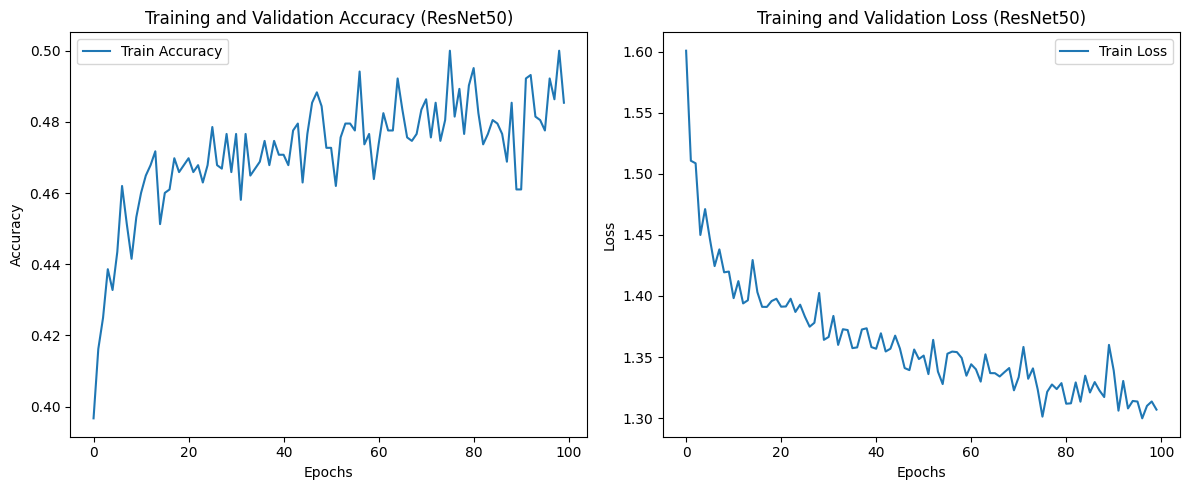

In [1]:
import os
import cv2
import numpy as np
import keras
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

output_dir = '/root/autodl-tmp/lfw'
threshold = 100  
images, labels, names = [], [], []
label = 1

for name in os.listdir(output_dir):
    class_dir = os.path.join(output_dir, name)
    if len(os.listdir(class_dir)) > threshold:
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            img = cv2.imread(file_path)
            img = cv2.resize(img, (200, 200))  
            images.append(img)
            labels.append(label)
        names.append(name)
        label += 1

images = np.array(images)
labels = np.array(labels)

images_train, images_test, labels_train, labels_test = train_test_split(images[:1000], labels[:1000], test_size=0.1)
class_number = len(names) + 1
images_train = images_train.astype('float32') / 255.0
images_test = images_test.astype('float32') / 255.0

labels_train_b = keras.utils.to_categorical(labels_train, class_number)
labels_test_b = keras.utils.to_categorical(labels_test, class_number)

def build_resnet50_model(class_number):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))  
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  
    x = Dropout(0.5)(x)  
    x = Dense(512, activation='relu')(x)  
    predictions = Dense(class_number, activation='softmax')(x)  

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = build_resnet50_model(class_number)

start_time = time.time()
history = model.fit(images_train, labels_train_b, epochs=100, batch_size=32, validation_data=(images_test, labels_test_b))
train_time = time.time() - start_time
print(f"ResNet50 train_time: {train_time} seconds")

test_loss, test_accuracy = model.evaluate(images_test, labels_test_b)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

model.save('ResNet50_model.h5')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Training and Validation Accuracy (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Training and Validation Loss (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
